In [1]:
# Input:
path_data = '../../01 data/shampoo.csv'
n_lag = 3

path_01 = '../../03 outputs/univariate/01/'
path_scaler = path_01 + 'time_scaler.pickle'
path_x_train = path_01 + 'X_train.npy'
path_y_train = path_01 + 'y_train.npy'
path_x_val = path_01 + 'X_val.npy'
path_y_val = path_01 + 'y_val.npy'
path_x_test = path_01 + 'X_test.npy'
path_y_test = path_01 + 'y_test.npy'

path_02 = '../../03 outputs/univariate/02/'
path_forecaster_univariate = path_02 + 'forecaster_univariate.hdf5'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import pickle
from keras.models import load_model

In [3]:
# Load data
data = pd.read_csv(path_data)
print(data.shape)
data.head(3)

(36, 2)


,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1


In [4]:
# Load data (lag 3 steps)
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))
X_test = np.load(open(path_x_test, 'rb'))
y_test = np.load(open(path_y_test, 'rb'))

In [7]:
# Load model and tokenizer
scaler = pickle.load(open(path_scaler, 'rb'))

forecaster_vanilla = load_model(path_forecaster_univariate)

In [8]:
def invert_transform_pred(pred, X_):
    # Invert the prediction scaling
    n_features = X_.shape[2]
    inv_X = X_.reshape((X_.shape[0], X_.shape[1] * X_.shape[2]))
    inv_X = np.concatenate((pred, inv_X[:, -n_features+1:]), axis=1)
    inv_X = scaler.inverse_transform(inv_X)
    inv_pred = inv_X[:,0]

    return inv_pred

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


# Vanilla LSTM

In [10]:
# Forecast train
pred_train_vanilla = forecaster_vanilla.predict(X_train, verbose=0)
pred_train_vanilla = invert_transform_pred(pred_train_vanilla, X_train)

# Forecast val
pred_val_vanilla = forecaster_vanilla.predict(X_val, verbose=0)
pred_val_vanilla = invert_transform_pred(pred_val_vanilla, X_val)

# Forecast test
pred_test_vanilla = forecaster_vanilla.predict(X_test, verbose=0)
pred_test_vanilla = invert_transform_pred(pred_test_vanilla, X_test)

In [26]:
# # Combine predictions
pred_train_vanilla = pd.DataFrame(pred_train_vanilla, columns=['prediction'])
pred_train_vanilla['split'] = 'train'

pred_val_vanilla = pd.DataFrame(pred_val_vanilla, columns=['prediction'])
pred_val_vanilla['split'] = 'val'

pred_test_vanilla = pd.DataFrame(pred_test_vanilla, columns=['prediction'])
pred_test_vanilla['split'] = 'test'

pred_vanilla = pd.concat([pred_train_vanilla, pred_val_vanilla, pred_test_vanilla], axis=0).reset_index(drop=True)
pred_vanilla.index = pred_vanilla.index + n_lag

# Combine with original data
pred_vanilla = pd.concat([data['Sales'], pred_vanilla], axis=1)

# Invert the stationary transformation (if implemented stationary transformation)
pred_vanilla['prediction'] = pred_vanilla['prediction'] + pred_vanilla['Sales'].shift(1)

print(pred_vanilla.shape)
pred_vanilla.head(8)

(36, 3)


,Sales,prediction,split
0,266.0,NaN,NaN
1,145.9,NaN,NaN
2,183.1,NaN,NaN
3,119.3,169.963419,train
4,180.3,190.491125,train
5,168.5,156.107493,train
6,231.8,195.160156,train
7,224.5,200.736636,train


In [27]:
# Check the split boundary
train_split = pred_vanilla[pred_vanilla['split']=='train'].index[-1]
val_split = pred_vanilla[pred_vanilla['split']=='val'].index[-1]
print(train_split, val_split)

24 30


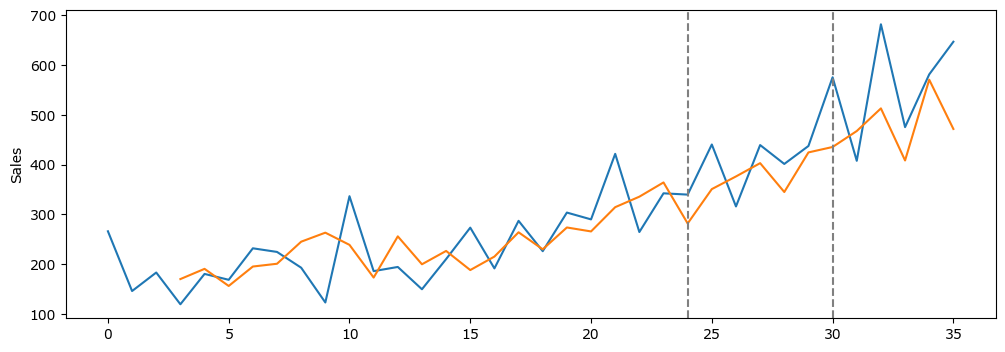

In [29]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred_vanilla, x=pred_vanilla.index, y='Sales')
sns.lineplot(pred_vanilla, x=pred_vanilla.index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

In [31]:
# Accuracy
mae_train = round(mean_absolute_error(pred_vanilla.loc[pred_vanilla['split']=='train', 'Sales'], pred_vanilla.loc[pred_vanilla['split']=='train', 'prediction']), 4)
mae_val = round(mean_absolute_error(pred_vanilla.loc[pred_vanilla['split']=='val', 'Sales'], pred_vanilla.loc[pred_vanilla['split']=='val', 'prediction']), 4)
mae_test = round(mean_absolute_error(pred_vanilla.loc[pred_vanilla['split']=='test', 'Sales'], pred_vanilla.loc[pred_vanilla['split']=='test', 'prediction']), 4)
print(f'training MAE: {mae_train}')
print(f'validation MAE: {mae_val}')
print(f'testing MAE: {mae_test}')

training MAE: 46.0425
validation MAE: 65.9531
testing MAE: 96.3769


In [ ]:
# Check the std of the train data
pred_vanilla[pred_vanilla['split']=='train']['Sales'].std()

78.45913390192815

In [32]:
# Save
pred_vanilla.to_csv('../../03 outputs/univariate/03/prediction_univariate.csv')